# Aim
This script aims to extract Fully disordered sequences from release_2023_06 with_ambiguous_evidences.json JSON, and save these fully disordered as our file style. \
Our JSON file style: \
    - a list of dict \
    - for each dict: 
        1. id;
        2. sequence;
        3. reference;
        4. contain_idr - 1/0
    

In [1]:
import json
from utils.file import dump_list2json, read_json2dict, read_json2list
import pandas as pd

from params.PDBparser import *

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics

# 1. Generate JSON & Fasta file

## 1.1. Load disprot dataset
>2649 sequences in total.

In [2]:
disprot_all_org = read_json2dict(path_disprot_all)
list_disprot_all_org = disprot_all_org['data']
disprot_all_org['size'], len(list_disprot_all_org)

(2649, 2649)

## 1.2. Extract & Save Disordered Sequences (Fully and Partially)
>disorder_content=1, fully disordered
>
>Disorder region term-codes:
>1. disorder ( IDPO:00076) A non-compact state in which atoms lack a fixed or ordered three-dimensional structure.
>2. molten globule ( IDPO:00077) A compact state, with native secondary structure but lacking specific native tertiary interactions.
>3. pre-molten globule ( IDPO:00078) A condensed but not compact state, with residual secondary structure, describing many native and non-native conformations in rapid equilibrium.

In [56]:
list_disprot_disordered = [] # to save fully disordered sequences
list_disprot_fully_disordered = [] # to save fully disordered sequences
list_disorder_terms = ['IDPO:00076', 'IDPO:00077', 'IDPO:00078']

In [57]:
for disprot_seq in list_disprot_all_org:
    
    disprot_id = disprot_seq['disprot_id']
    acc = disprot_seq['acc'] # Uniprot ID
    disorder_content = disprot_seq['disorder_content'] # proportion of disorder [0, 1]
    seq = disprot_seq['sequence']
    length = disprot_seq['length']
    contain_idr = 0
    reference = [0] * length # use to save disordered annotations
    
    if disorder_content==1: # check if the sequence is fully disordered
        reference = [1] * length
        contain_idr = 1
    else:
        regions = disprot_seq['regions']
        for r in regions:
            if r['term_id'] not in  list_disorder_terms:
                continue
            contain_idr = 1
            # update disordered annotation
            reference[(r['start']-1): r['end']] = [1] * (r['end']-r['start']+1)
    
    reference = ''.join([str(r) for r in reference])
    dict_seq = {
        'id': disprot_id, 'acc': acc, 'sequence': seq, 'length': length,
        'disorder_content': disorder_content,
        'reference': reference, 'contain_idr': contain_idr
    }
    
    if disorder_content == 1: # Fully disordered proteins
        list_disprot_fully_disordered.append(dict_seq)
        
    list_disprot_disordered.append(dict_seq)

**Saving**

In [58]:
dump_list2json(list_disprot_fully_disordered, path_disprot_dataset_fullDisordered)
dump_list2json(list_disprot_disordered, path_disprot_dataset_disordered)

## 1.3. Save to Fasta file

In [2]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO

In [3]:
list_disprot_fully_disordered = read_json2list(path_disprot_dataset_fullDisordered)
list_records = []

for linker_info in list_disprot_fully_disordered:
    record = SeqRecord(
        Seq(linker_info['sequence']),
        id=linker_info['id'],
        name=f'acc:{linker_info["acc"]}'
    )

    list_records.append(record)

In [4]:
with open(path_disprot_dataset_fullDisordered_seq, "w") as output_handle:
    SeqIO.write(list_records, output_handle, "fasta")

In [5]:
len(list_records)

184

# 2. Some analysis

In [2]:
list_disprot_fully_disordered = read_json2list(path_disprot_dataset_fullDisordered)
list_disprot_disordered = read_json2list(path_disprot_dataset_disordered)

In [3]:
df_disprot_fully_disordered = pd.DataFrame(list_disprot_fully_disordered)
df_disprot_disordered = pd.DataFrame(list_disprot_disordered)

In [61]:
df_disprot_disordered[df_disprot_disordered['contain_idr']==0]

,id,acc,sequence,length,disorder_content,reference,contain_idr
296,DP00464,Q13485,MDNMSITNTPTSNDACLSIVHSLMCHRQGGESETFAKRAIESLVKK...,552,0.065217,0000000000000000000000000000000000000000000000...,0


In [62]:
df_disprot_fully_disordered

,id,acc,sequence,length,disorder_content,reference,contain_idr
0,DP00005,P03045,MDAQTRRRERRAEKQAQWKAANPLLVGVSAKPVNRPILSLNRKPKS...,107,1,1111111111111111111111111111111111111111111111...,1
1,DP00008,Q64693,MLWQKSTAPEQAPAPPRPYQGVRVKEPVKELLRRKRGHTSVGAAGP...,256,1,1111111111111111111111111111111111111111111111...,1
2,DP00015,P61926,MTDVETTYADFIASGRTGRRNAIHDILVSSASGNSNELALKLAGLD...,76,1,1111111111111111111111111111111111111111111111...,1
3,DP00016,P38936,MSEPAGDVRQNPCGSKACRRLFGPVDSEQLSRDCDALMAGCIQEAR...,164,1,1111111111111111111111111111111111111111111111...,1
4,DP00017,P49918,MSDASLRSTSTMERLVARGTFPVLVRTSACRSLFGPVDHEELSREL...,316,1,1111111111111111111111111111111111111111111111...,1
...,...,...,...,...,...,...,...
179,DP03563,P04611,MDPVDPNLEPWNHPGSQPRTPCNKCHCKKCCYHCPVCFLNKGLGIS...,99,1,1111111111111111111111111111111111111111111111...,1
180,DP03565,P20893,MEPVDPRLEPWKHPGSQPKTASNNCYCKRCCLHCQVCFTKKGLGIS...,101,1,1111111111111111111111111111111111111111111111...,1
181,DP03852,P0ABK7,MKNKLLFMMLTILGAPGIAAAAGYDLANSEYNFAVNELSKSSFNQA...,151,1,1111111111111111111111111111111111111111111111...,1
182,DP03853,P28307,MKLLKVAAIAAIVFSGSALAGVVPQYGGGGNHGGGGNNSGPNSELN...,151,1,1111111111111111111111111111111111111111111111...,1


In [63]:
def plot_lengthDist(df: pd.DataFrame, column_name: str, title: str, set_color=False):
    sns.set(rc={'figure.figsize':(10,6)})
    if set_color:
        colors = sns.color_palette()
        ax = sns.histplot(data=df, x=column_name, color=colors[1])
    ax = sns.histplot(data=df, x=column_name)
    ax.set_xlabel('Length', fontsize=15)
    ax.set_ylabel('Count', fontsize=15)
    ax.set_title(title, fontsize=20)
    ax.get_figure().savefig(title+'.jpg')
    return ax

/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

<Axes: title={'center': 'Disprot: Fully disordered sequence length distribution'}, xlabel='Length', ylabel='Count'>

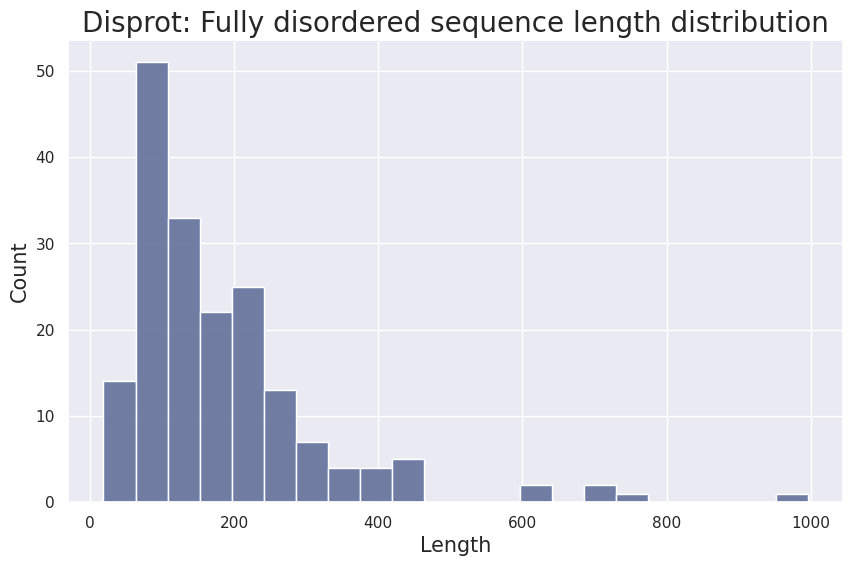

In [64]:
title = 'Disprot: Fully disordered sequence length distribution'
column_name = 'length'
plot_lengthDist(df_disprot_fully_disordered, column_name, title, set_color=True)

/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

<Axes: title={'center': 'Disprot: Sequence length distribution'}, xlabel='Length', ylabel='Count'>

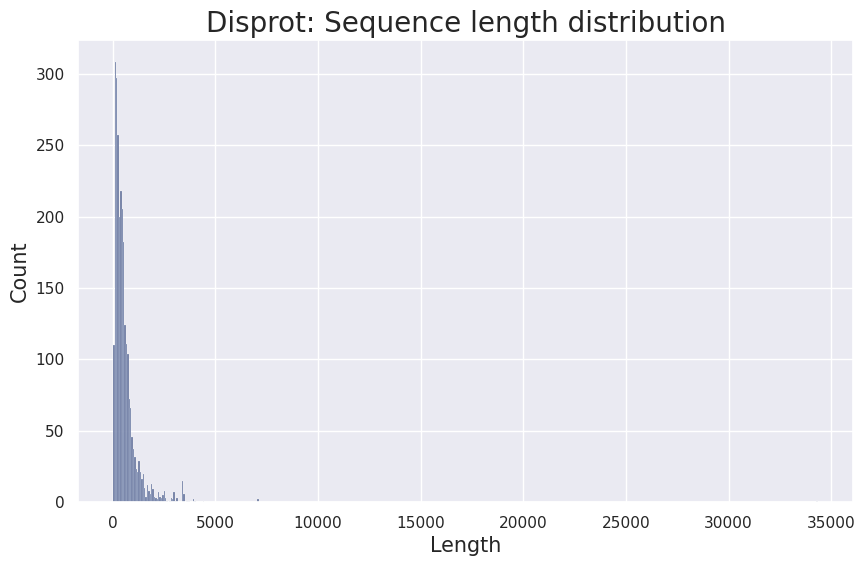

In [11]:
title = 'Disprot: Sequence length distribution'
column_name = 'length'
plot_lengthDist(df_disprot_disordered, column_name, title, set_color=True)

In [25]:
df_disprot_fully_disordered_plot = df_disprot_fully_disordered[['length', 'reference']]
df_disprot_fully_disordered_plot = df_disprot_fully_disordered_plot.rename({'length': 'Sequence Length'}, axis=1)
df_disprot_fully_disordered_plot.loc[:, 'Sequence Type'] = 'Fully Disordered'

df_disprot_disordered_plot = df_disprot_disordered[['length', 'reference']]
df_disprot_disordered_plot = df_disprot_disordered_plot.rename({'length': 'Sequence Length'}, axis=1)
df_disprot_disordered_plot.loc[:, 'Sequence Type'] = 'ALL'

df_plot = pd.concat([df_disprot_fully_disordered_plot, df_disprot_disordered_plot], ignore_index=True)

/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dimeng/miniconda3/envs/py11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/tmp/ipykernel_122570/2233113253.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

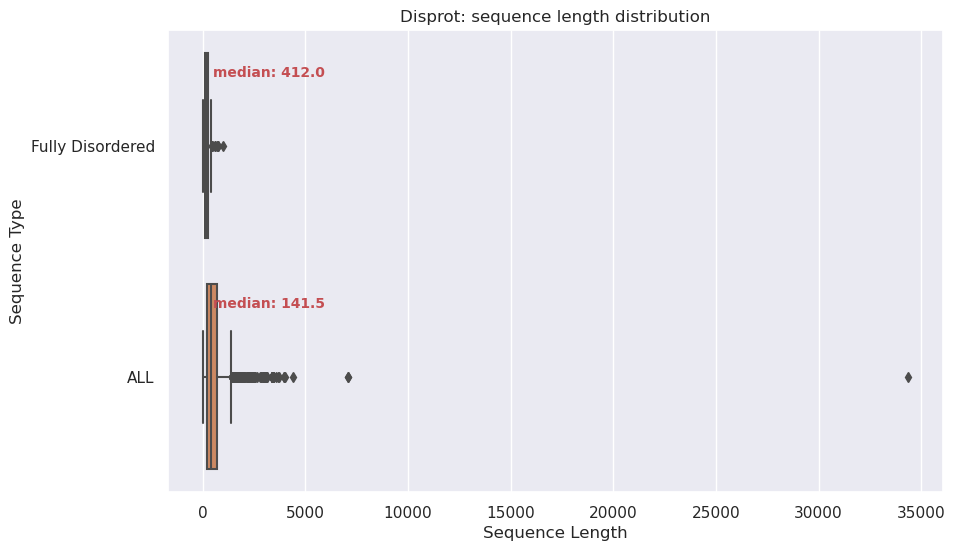

In [26]:
fig = sns.boxplot(x=df_plot["Sequence Length"], y=df_plot["Sequence Type"])

medians = df_plot.groupby(['Sequence Type'])['Sequence Length'].median()
vertical_offset = df_plot['Sequence Length'].median() # offset from median for display
medians_info = [f'median: {medians[0]}', f'median: {medians[1]}']
for ytick in fig.get_yticks():
    fig.text(ytick + vertical_offset+100, ytick-0.3,medians_info[ytick], 
            horizontalalignment='left',size='small',color='r',weight='semibold')

title = 'Disprot: sequence length distribution'
fig.set_title(title)
fig.get_figure().savefig(f'{title}.jpg')

In [31]:
num_idr = 0
num_aa = 0
for seq in list_disprot_disordered:
    num_idr += sum(seq['reference'])
    num_aa += len(seq['reference'])
num_idr/num_aa

0.16746502323954873

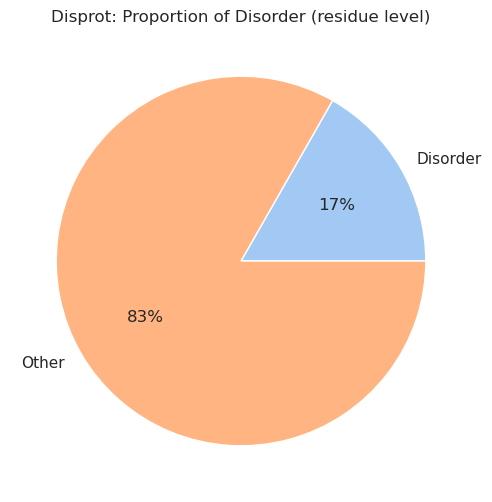

In [40]:
#define data
data = [num_idr, num_aa-num_idr]
labels = ['Disorder', 'Other']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:2]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
title = 'Disprot: Proportion of Disorder (residue level)'
plt.title(title)
plt.savefig(title)
plt.show()

# 3. Merge with IDR30 JSON file
>Note that, this version of training dataset exclude the sequences from CAID
>
>187 fully disordered sequences
>
>181 left after excluding CAID sequences

### Two dataset
>save all dataset into one JSON file
>Separate it into Train & Test sets. Add 181 fully disordered sequences to train set only. 

In [4]:
list_idr = read_json2list(path_IDRdataset)
df_idr = pd.DataFrame(list_idr)
list_caid = read_json2list(path_caid_dataset_json)
df_caid = pd.DataFrame(list_caid)
list_caidID = list(df_caid['id'])

df_disprot = df_disprot_fully_disordered[~(df_disprot_fully_disordered['id'].isin(list_caidID))]

In [9]:
list_idr_train = read_json2list(path_train)
df_idr_train = pd.DataFrame(list_idr_train)


list_idr_test = read_json2list(path_test)
df_idr_test = pd.DataFrame(list_idr_test)

In [10]:
df_disprot[:2]

,id,acc,sequence,length,disorder_content,reference,contain_idr
0,DP00005,P03045,MDAQTRRRERRAEKQAQWKAANPLLVGVSAKPVNRPILSLNRKPKS...,107,1,1111111111111111111111111111111111111111111111...,1
1,DP00008,Q64693,MLWQKSTAPEQAPAPPRPYQGVRVKEPVKELLRRKRGHTSVGAAGP...,256,1,1111111111111111111111111111111111111111111111...,1


In [11]:
df_disprot_fully_disordered[:2]

,id,acc,sequence,length,disorder_content,reference,contain_idr
0,DP00005,P03045,MDAQTRRRERRAEKQAQWKAANPLLVGVSAKPVNRPILSLNRKPKS...,107,1,1111111111111111111111111111111111111111111111...,1
1,DP00008,Q64693,MLWQKSTAPEQAPAPPRPYQGVRVKEPVKELLRRKRGHTSVGAAGP...,256,1,1111111111111111111111111111111111111111111111...,1


### Save all dataset

In [16]:
df_IDR_fullyDisordered = pd.concat([df_idr, df_disprot.loc[:, ['id', 'sequence', 'reference']]], ignore_index=True)
list_IDR_fullyDisordered = json.loads(df_IDR_fullyDisordered.to_json(orient="records"))

dump_list2json(list_IDR_fullyDisordered, path_IDR_fullyDisordered_dataset)

### save Train & Test

In [14]:
df_IDR_fullyDisordered_train = pd.concat([df_idr_train.loc[:, ['id', 'sequence', 'reference']], df_disprot.loc[:, ['id', 'sequence', 'reference']]], ignore_index=True)
list_IDR_fullyDisordered_train = json.loads(df_IDR_fullyDisordered_train.to_json(orient="records"))

list_IDR_test = json.loads(df_idr_test.loc[:, ['id', 'sequence', 'reference']].to_json(orient="records"))
dump_list2json(list_IDR_fullyDisordered_train, path_train_withFullyDisorder)
dump_list2json(list_IDR_test, path_test_withFullyDisorder)

In [15]:
768+1024

1792

# 4. Merge with IDR100 JSON file
>Note that, this version of training dataset exclude the sequences from CAID
>
>187 fully disordered sequences
>
>181 left after excluding CAID sequences

### Two dataset
>save all dataset into one JSON file
>Separate it into Train & Test sets. Add 181 fully disordered sequences to train set only. 

In [2]:
list_idr = read_json2list(path_IDRdataset_100)
df_idr = pd.DataFrame(list_idr)
list_caid = read_json2list(path_caid_dataset_json)
df_caid = pd.DataFrame(list_caid)
list_caidID = list(df_caid['id'])

In [6]:
df_disprot_fully_disordered = pd.DataFrame(read_json2list(path_disprot_dataset_fullDisordered))
df_disprot = df_disprot_fully_disordered[~(df_disprot_fully_disordered['id'].isin(list_caidID))]

In [11]:
df_disprot.loc[:, 'fold'] = 0
df_disprot.loc[:, 'clstr_id'] = 'disprot'

In [13]:
df_IDR_fullyDisordered = pd.concat([df_idr, df_disprot.loc[:, ['id', 'sequence', 'reference', 'fold', 'clstr_id']]], ignore_index=True)
list_IDR_fullyDisordered = json.loads(df_IDR_fullyDisordered.to_json(orient="records"))

dump_list2json(list_IDR_fullyDisordered, path_IDR_fullyDisordered_dataset_100)

In [14]:
df_IDR_fullyDisordered

,id,sequence,reference,fold,clstr_id
0,120L_1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSAKSEL...,0000000000000000000000000000000000000000000000...,4,7DDZ_1
1,13PK_1,EKKSINECDLKGKKVLIRVDFNVPVKNGKITNDYRIRSALPTLKKV...,0000000000000000000000000000000000000000000000...,1,1LTK_1
2,155L_1,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,0000000000000000000000000000000000000000000000...,4,7DDZ_1
3,15C8_1,DIVLTQSPAIMSASLGERVTMTCTASSSVSSSNLHWYQQKPGSSPK...,0000000000000000000000000000000000000000000000...,3,4YDV_2
4,15C8_2,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQKPEQGLE...,0000000000000000000000000000000000000000000000...,4,1IGT_2
...,...,...,...,...,...
79144,DP03563,MDPVDPNLEPWNHPGSQPRTPCNKCHCKKCCYHCPVCFLNKGLGIS...,1111111111111111111111111111111111111111111111...,0,disprot
79145,DP03565,MEPVDPRLEPWKHPGSQPKTASNNCYCKRCCLHCQVCFTKKGLGIS...,1111111111111111111111111111111111111111111111...,0,disprot
79146,DP03852,MKNKLLFMMLTILGAPGIAAAAGYDLANSEYNFAVNELSKSSFNQA...,1111111111111111111111111111111111111111111111...,0,disprot
79147,DP03853,MKLLKVAAIAAIVFSGSALAGVVPQYGGGGNHGGGGNNSGPNSELN...,1111111111111111111111111111111111111111111111...,0,disprot


In [18]:
len(df_IDR_fullyDisordered.loc[:, 'clstr_id'].drop_duplicates())

23528